# BIG DATA 
###### STREAMING TWITTER &  PHÂN TÍCH XU HƯỚNG SỬ DỤNG ĐIỆN THOẠI CỦA NGƯỜI DÙNG TWITTER

###### Giảng viên hướng dẫn: Tiến sĩ Trần Việt Trung
###### Nhóm thực hiện: Nhóm 5
+ Phạm Minh Khiêm - 20170084
+ Nguyễn Văn Chức - 20170044
+ Trần Thị Uyên   - 20170223
+ Ngô Văn Giang   - 20170065

# 1. Tổng quan
    Mục đích :
    - Nhóm mong muốn xây dựng mô phỏng một hệ thống big data, mục đích là streaming twitter tweets của người dùng twitter từ hệ thống TWITTER API, tiền xử lý dữ liệu, lưu vào hệ thống và thực hiện các tính toán phân tích về xu hướng sử dụng điện thoại của người dùng TWITTER
    - Các thông tin phân tích trả lời các câu hỏi :
        + Người dùng TWITTER sử dụng thiết bị nào để truy cập ?
        + Người dùng TWITTER sử dụng các thiết bị IOS hay sử dụng các thiết bị ANDROID ? 
        + Quốc gia nào có nhiều người dùng sử dụng thiết bị IOS nhất dựa trên lịch sử tweet ?
        + Quốc gia nào có nhiều người dùng thích sử dụng thiết bị ANDROID nhất ?
        + ..
    - Hệ thống mô phỏng bao gồm các thành phần như một hệ thống thật, cài đặt trên máy ảo Docker
    - Các thành phần trong hệ thống :
        + 1 Cụm kafka dùng để streaming dữ liệu
        + 1 Cụm spark dùng để xử lý streaming và phân tích 
        + 1 Cụm hadoop dùng để lưu trữ dữ liệu phục vụ mục đích phân tích
        + 1 Application nhận đầu vào là TWITTER API, đẩy dữ liệu vào kafka
        + 1 Pyspark notebook để phân tích, visualize

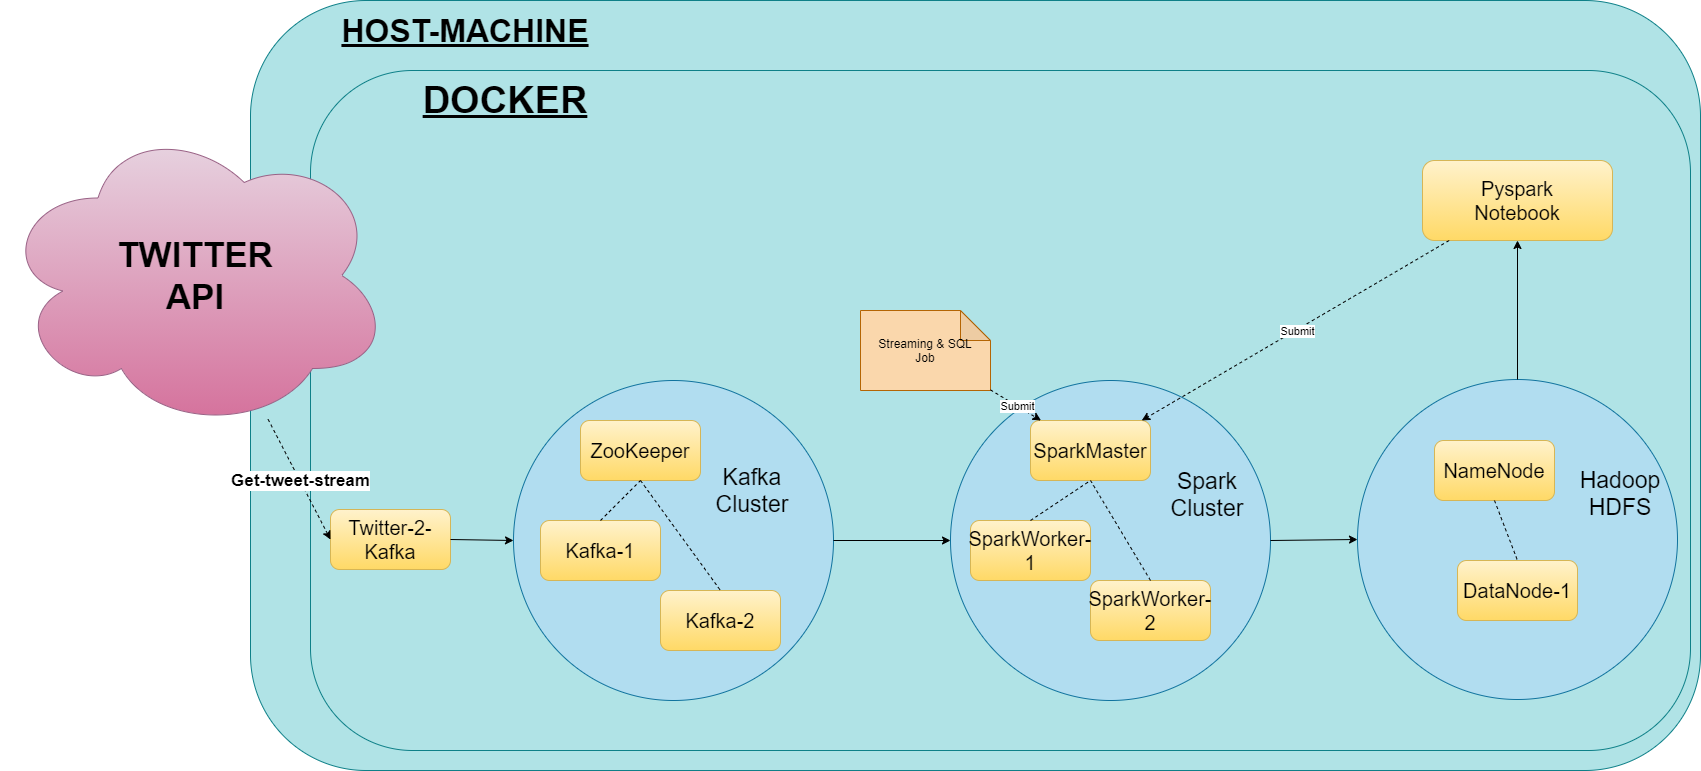

In [2]:
from IPython.display import Image
Image("D:\docker\diagram.png")

# 2. Xây dựng hệ thống
## 2.1 Cụm kafka 
 - Gồm 1 Zookeeper và 2 kafka broker
 - Khởi tạo topic twittertweet với 3 partition và 1 replicate với cú pháp :
     docker-compose exec -T kafka-broker-1 kafka-topics.sh \
             --create --bootstrap-server kafka-broker-1:9093 \
             --replication-factor 1 --partitions 3 \
             --topic twittertweet

In [ ]:
  # DOCKER COMPOSE
  zookeeper:
    image: zookeeper:3.4.10
    container_name: zookeeper
    environment:
      ZOO_MY_ID: 1
      ZOO_SERVERS: server.1=0.0.0.0:2888:3888
      ZOO_TICK_TIME: 15000
    ports:
      - 2181:2181      
  kafka-broker-1:
    image: wurstmeister/kafka:2.12-2.2.1
    container_name: kafka-broker-1
    depends_on:
      - zookeeper
    ports:
      - "9092:9092"
    environment:
      - KAFKA_ZOOKEEPER_CONNECT=zookeeper:2181
      - ALLOW_PLAINTEXT_LISTENER=yes
      - KAFKA_ADVERTISED_LISTENERS=INSIDE://kafka-broker-1:9093,OUTSIDE://localhost:9092
      - KAFKA_LISTENER_SECURITY_PROTOCOL_MAP=INSIDE:PLAINTEXT,OUTSIDE:PLAINTEXT
      - KAFKA_LISTENERS=INSIDE://kafka-broker-1:9093,OUTSIDE://0.0.0.0:9092
      - KAFKA_INTER_BROKER_LISTENER_NAME=INSIDE
  kafka-broker-2:
    image: wurstmeister/kafka:2.12-2.2.1
    container_name: kafka-broker-2
    depends_on:
      - zookeeper
      - kafka-broker-1
    ports:
      - "9094:9094"
    environment:
      - KAFKA_ZOOKEEPER_CONNECT=zookeeper:2181
      - ALLOW_PLAINTEXT_LISTENER=yes
      - KAFKA_ADVERTISED_LISTENERS=INSIDE://kafka-broker-2:9093,OUTSIDE://localhost:9094
      - KAFKA_LISTENER_SECURITY_PROTOCOL_MAP=INSIDE:PLAINTEXT,OUTSIDE:PLAINTEXT
      - KAFKA_LISTENERS=INSIDE://kafka-broker-2:9093,OUTSIDE://0.0.0.0:9094
      - KAFKA_INTER_BROKER_LISTENER_NAME=INSIDE

## 2.2 Cụm Spark
- Gồm 1 Spark master và 2 spark-worker :

In [ ]:
  spark-master:
    image: bde2020/spark-master:2.4.5-hadoop2.7
    container_name: spark-master
    ports:
      - "8080:8080"
      - "7077:7077"
    environment:
      - INIT_DAEMON_STEP=setup_spark
    volumes:
      - "D:/Code/IdeaProjects/bigdata/spark-stream-kafka/target:/spark/target"
  spark-worker-1:
    image: bde2020/spark-worker:2.4.5-hadoop2.7
    container_name: spark-worker-1
    depends_on:
      - spark-master
    ports:
      - "28081:8081"
      - "4041:4040"
    environment:
      - "SPARK_MASTER=spark://spark-master:7077"
      - "SPARK_SHUFFLE_SERVICE_ENABLED=true"
    volumes:
      - "./target:/spark/target"
  spark-worker-2:
    image: bde2020/spark-worker:2.4.5-hadoop2.7
    container_name: spark-worker-2
    depends_on:
      - spark-master
    ports:
      - "28082:8081"
      - "4040:4040"
    environment:
      - "SPARK_MASTER=spark://spark-master:7077"
      - "SPARK_SHUFFLE_SERVICE_ENABLED=true"
    volumes:
      - "./target:/spark/target"

## 2.3 Cụm Hadoop :

In [ ]:
  namenode:
    image: bde2020/hadoop-namenode:2.0.0-hadoop3.2.1-java8
    container_name: namenode
    restart: always
    ports:
      - 9870:9870
      - 9000:9000
    volumes:
      - hadoop_namenode:/hadoop/dfs/name
    environment:
      - CLUSTER_NAME=test
    env_file:
      - ./hadoop.env

  datanode:
    image: bde2020/hadoop-datanode:2.0.0-hadoop3.2.1-java8
    container_name: datanode
    restart: always
    volumes:
      - hadoop_datanode:/hadoop/dfs/data
    environment:
      SERVICE_PRECONDITION: "namenode:9870"
    env_file:
      - ./hadoop.env
  
  resourcemanager:
    image: bde2020/hadoop-resourcemanager:2.0.0-hadoop3.2.1-java8
    container_name: resourcemanager
    restart: always
    environment:
      SERVICE_PRECONDITION: "namenode:9000 namenode:9870 datanode:9864"
    env_file:
      - ./hadoop.env

  nodemanager1:
    image: bde2020/hadoop-nodemanager:2.0.0-hadoop3.2.1-java8
    container_name: nodemanager
    restart: always
    environment:
      SERVICE_PRECONDITION: "namenode:9000 namenode:9870 datanode:9864 resourcemanager:8088"
    env_file:
      - ./hadoop.env
  
  historyserver:
    image: bde2020/hadoop-historyserver:2.0.0-hadoop3.2.1-java8
    container_name: historyserver
    restart: always
    environment:
      SERVICE_PRECONDITION: "namenode:9000 namenode:9870 datanode:9864 resourcemanager:8088"
    volumes:
      - hadoop_historyserver:/hadoop/yarn/timeline
    env_file:
      - ./hadoop.env
volumes:
  hadoop_namenode:
  hadoop_datanode:
  hadoop_historyserver:

## 2.4 Pyspark-notebook
 Do nhóm sử dụng spark version 2.4.5 với python 2.7 , các phiên bản pyspark image trên docker-hub hiện nay đều có python3,
pyspark 3.0.1 không thể hoạt động đúng vs hệ thống, vì vậy nhóm tự build 1 image pyspark-notebook với thông số phù hợp
(python 2.5, pyspark 2.4.5, java 8), Dockerfile được đính kèm.

In [ ]:
pyspark:
     image: khiempmk/pyspark-nodebook:2.4.5 
     container_name: pyspark-notebook
     ports:
      - "8888:8888" 
     environment:
      - JUPYTER_TOKEN=easy

## 2.5 Application kafka producer nhận dữ liệu từ twitterAPI, bắn vào kafka của hệ thống :
 Để tiện cho việc deploy lên hệ thống, nhóm sử dụng ngôn ngữ lập trình JAVA, code được build thành Docker image, xử dụng thư viện twitter4j, Dockerfile và
code được đính kèm .

In [ ]:
twitter-stream:
     image : khiempmk/twitter_stream_kafka:lastest
     container_name : twitter-stream
     depends_on:
      - kafka-broker-1
      - kafka-broker-2
     volumes:
      - "./conf/:/usr/local/service/conf"

## 2.6 Streaming spark job
  Job với nhiệm vụ xử lý streaming dữ liệu nhận về từ kafka :
   - filter lọc loại bỏ các trường dữ liệu dư thừa 
   -  map reduce để đếm số lượng người dùng các loại thiết bị,
   -  lưu dữ liệu vào hdfs ( partitionby "yyyyMMdd" và "hh" ) để tối ưu việc truy vấn theo khoảng thời gian theo định dạng
          Ví dụ :
          -|- Data
          -|-------|- storeData
          -|-------|-----|- day=20201224
          -|-------|-----|-------|- hour= 6
          -|-------|-----|-------|-------|- partitionXXX.csv
          -|-------|-----|-------|-------|- partitionXXX.csv
          -|-------|-----|-------|- hour= 7
          -|-------|- partitionbyDevice
          -|-------|-----|- day=20201223
          -|-------|-----|-------|- hour= 5
          -|-------|-----|-------|- hour= 6
          -|-------|- partitionbyCountry
          -|-------|-----|- day=20201212
          -|-------|-----|-------|- hour= 5
          -|-------|-----|-------|- hour= 6
          
  Code được đính kèm ,
  Job được submit lên cụm spark bằng command :

In [ ]:
docker-compose exec -T spark-master \
    spark/bin/spark-submit --class vn.hust.k62.kstn.project.sparkstreamkafka.SparkProcessor \
    --master spark://spark-master:7077 --deploy-mode cluster \
    --executor-cores 2 --executor-memory 1.5G \
    spark/target/spark-stream-kafka-1.0-SNAPSHOT-jar-with-dependencies.jar


 # 3.  Chạy thử nghiệm hệ thống & phân tích :
 ## 3.1. Thử nghiệm hệ thống Streaming :
 Vì giới hạn phần cứng, nhóm chạy hệ thống với cấu hình :\
 + Spark stream interval time : 30s
 + Input rate = 2 tweet/ s và input rate = 10 tweet/s
 + Kakfka topic gồm 2 partition và 1 replication

Kết quả chạy khi bật hệ thống :
- Spark Job log khi start hệ thống khoảng 30 phút

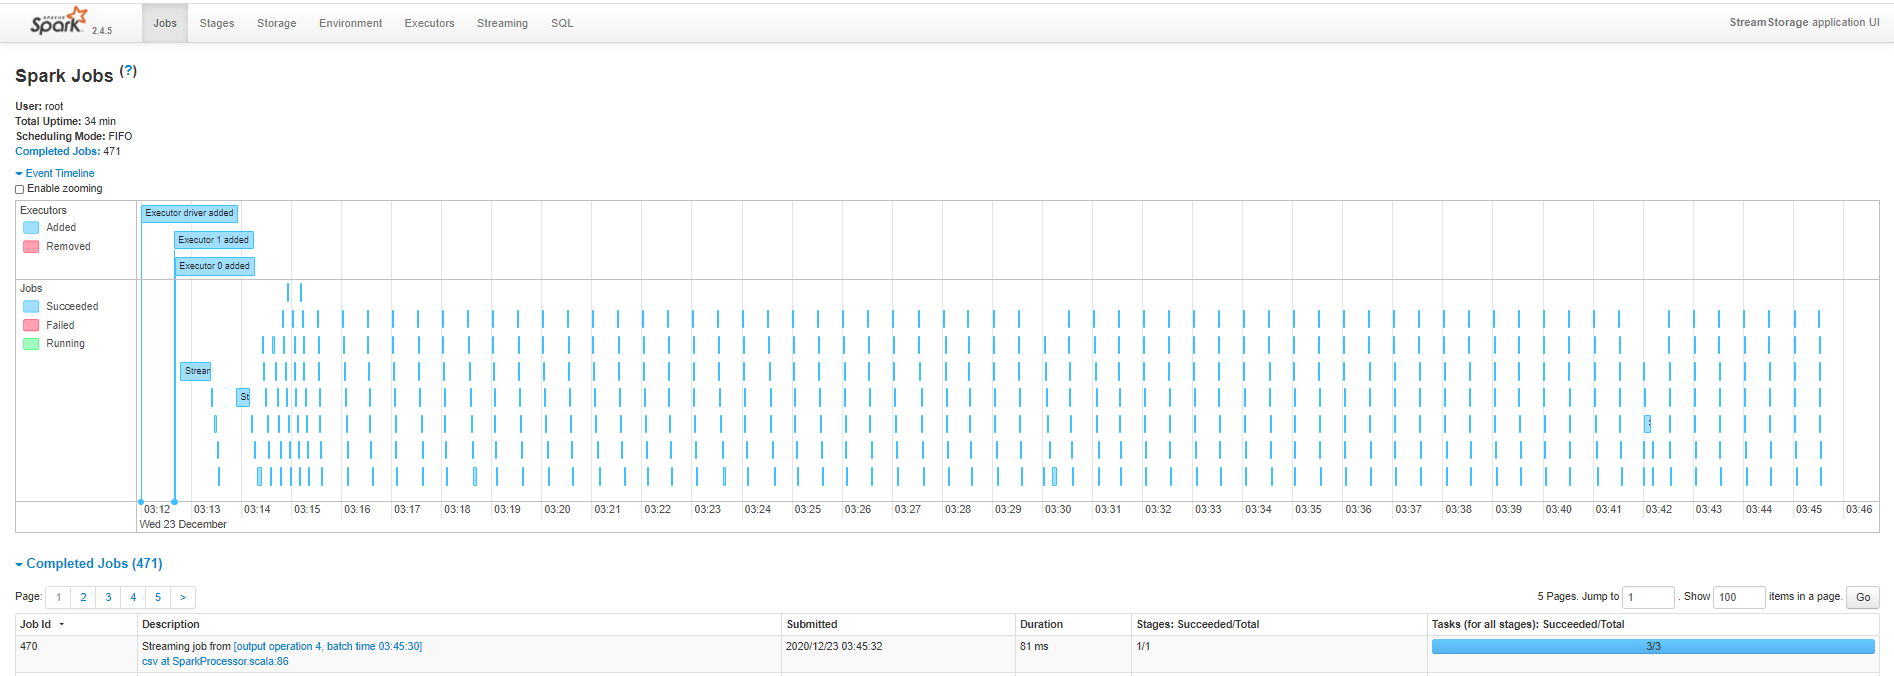

In [5]:
Image("D:/docker/result/spark-streaming-job.png")

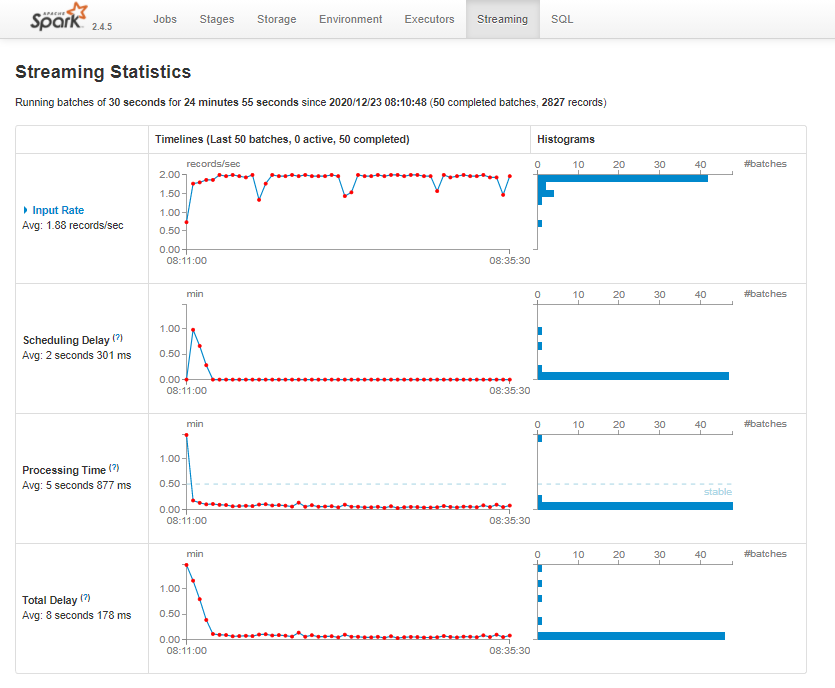

In [9]:
Image("D:/docker/result/rate2.png")
# Streaming statistics with input rate 2 records/s

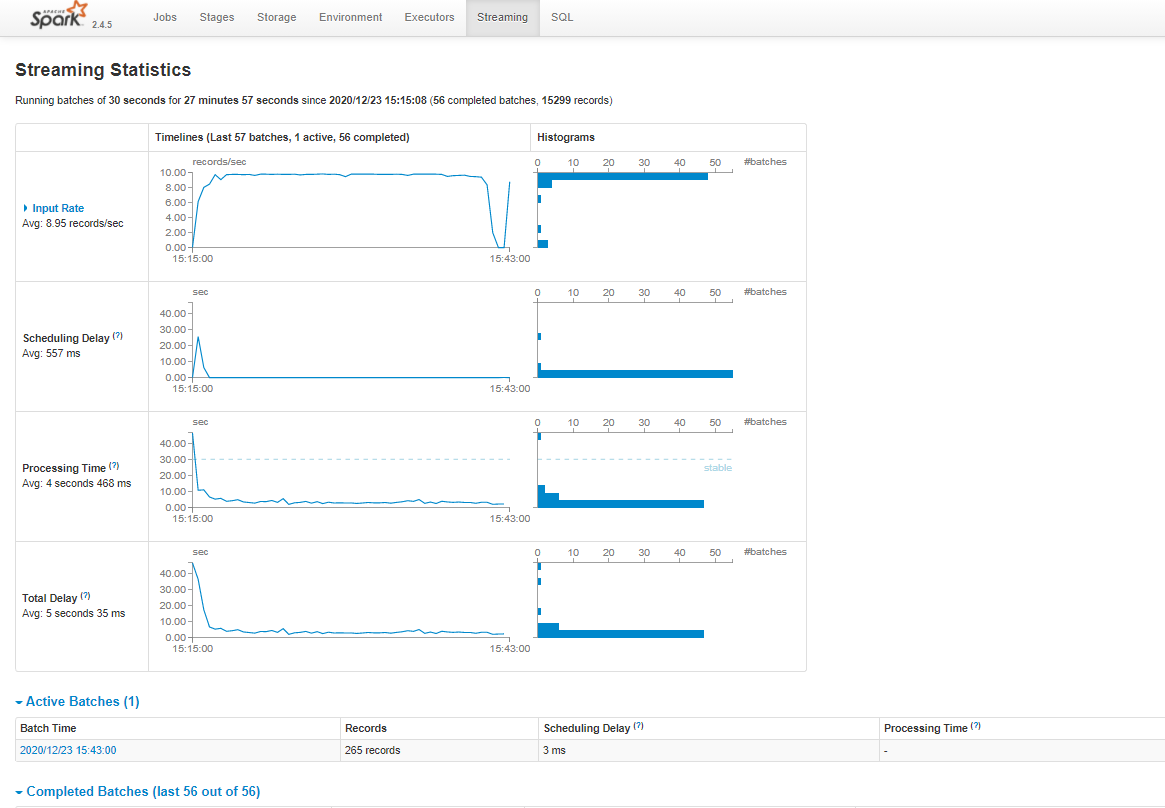

In [8]:
Image("D:/docker/result/stream-statisc.png")
# Streaming statistics with input rate 10 records/s

## 3.2. Phân tích dữ liệu bằng spark

### 3.2.1. Xu hướng sử dụng các thiết bị trong truy cập Twitter
Trước tiên cần phải lấy dữ liệu đã lưu trong hdfs datanode

In [1]:
from pyspark.sql import SparkSession
sparkSession = SparkSession.builder.appName("test").getOrCreate()
df_load = sparkSession.read.csv('hdfs://namenode:9000/chuc/data/partitionbyDevice/day=20201222/hour=08')
# df_load = sparkSession.read.csv('chuc/data/partitionbyDevice/day=20201222/hour=08')
df_load.show()

+---------------------+---+-------------------+
|                  _c0|_c1|                _c2|
+---------------------+---+-------------------+
|          NLnlNlLnLNL|  1|2020/12/22 08:01:00|
|ツイタマ+ for Android|  1|2020/12/22 08:01:00|
|            TweetDeck|  5|2020/12/22 08:01:00|
|         Tabtter Free|  1|2020/12/22 08:01:00|
|         Rakuten,Inc.|  1|2020/12/22 08:01:00|
| Nintendo Switch S...|  1|2020/12/22 08:01:00|
|     Twitter for iPad| 29|2020/12/22 08:01:00|
|         twittbot.net| 12|2020/12/22 08:01:00|
|             OnlyFans|  1|2020/12/22 08:01:00|
|        Nadal Blessed|  1|2020/12/22 08:01:00|
|     Tweetbot for iΟS|  1|2020/12/22 08:01:00|
|  Twidere for Android|  1|2020/12/22 08:01:00|
|                 null|  2|2020/12/22 08:01:00|
| Twitcom - Comunid...|  4|2020/12/22 08:01:00|
|           EtsySocial|  1|2020/12/22 08:01:00|
|        WordPress.com|  3|2020/12/22 08:01:00|
|       Hootsuite Inc.|  1|2020/12/22 08:01:00|
|               fllwrs|  3|2020/12/22 08:01:

Trong kết quả thu được từ bảng trên cột **_c0** là loại thiết bị truy cập. Các thiết bị này không chỉ là các thiết bị điện tử cá nhân mà còn chứa các loại thiết bị khác được Twitter nhận diện như là một thiết bị truy cập. VD: các trang web truy cập đến hoặc các phần mềm trò chơi cho phép chia sẻ kết quả trên nền tảng này,...\
Cột **_c1** là số lương các thiết bị đếm được lấy từ kafka trong khoảng thời gian 30s\
Côt **_c2** tương ứng là thời điểm bắt đầu tính để lấy số liệu từ cột **_c1**\
\
Trong bước tiếp theo chúng ta cần xây dựng 1 hàm để trích xuất ra thông tin cần thiết. Cụ thể trong trường hợp hiện tại là số lượng thiết bị tương ứng với 3 loại thiết bị là __Android__, __Iphone__, __Ipad__

In [4]:
from datetime import datetime
from pyspark.sql.functions import *
def getslot(df,stoptime, interval):
    '''
    Hàm lấy số lượng các thiết bị tương ứng cho từng loại thiết bị.
    @df: dataframe cần trích xuất
    @stopTime: cận dưới của thời điểm dừng xét
    @interval: khoảng thời gian cần lấy đổ về trước tính từ stopTime
    '''
    stop_time=datetime.strptime(stoptime, '%Y/%m/%d %H:%M:%S').timestamp()
    start_time= datetime.strftime(datetime.fromtimestamp(stop_time - interval), '%Y/%m/%d %H:%M:%S')
#     print(start_time)
    # lấy các dữ liệu trong khoảng thời gian yêu cầu.
    caredata= df.filter((df._c2 >= start_time) & (df._c2 <= stoptime))
    
    caredata= caredata.withColumn("int_res",df["_c1"].cast("int")) 
    # tính tổng các thiết bị tương ứng
    caredata= caredata.groupBy("_c0").agg(sum("int_res")).sort(desc("sum(int_res)"))
    # đặt lại tên cột
    caredata= caredata.withColumnRenamed('sum(int_res)', 'num_of_device')
    # tìm số lượng các thiết bị ứng với 3 thiết bị quan tâm
    caredata= caredata[caredata._c0.isin("Twitter for Android", "Twitter for iPhone","Twitter for iPad")]
    return caredata

Mô tả theo thời gian lượng thiết bị truy cập twitter theo từng loại:

In [ ]:
%matplotlib nbagg
import random
from itertools import count
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import numpy as np
# plt.style.use('fivethirtyeight')

stopTime = "2020/12/22 08:15:00"
interval = 15*60
subTime = 30
  
nValues =  10
x_vals = np.arange(nValues)
y = []
for _ in range(3):
    y.append([0 for i in range(nValues)])
    
fig = plt.subplots(figsize=(10, 5))
def animate(i):
    global stopTime
    #data = pd.read_csv('data.csv')
    x = x_vals
    df =  getslot(df_load,stopTime, interval).collect()
    for i in range(3):
        for j in range(nValues-1):
            y[i][j] = y[i][j+1];

    y[0][nValues-1] = df[0][1];
    y[1][nValues-1] = df[1][1];
    y[2][nValues-1] = df[2][1]; 
    plt.cla()
    plt.plot(x, y[0], label='Android')
    plt.plot(x, y[1], label='iPhone')
    plt.plot(x, y[2], label='iPad')
    plt.text(10, 2, stopTime, size=16, ha='right')
    plt.legend(loc='upper left')
    plt.tight_layout()
    stop_time=datetime.strptime(stopTime, '%Y/%m/%d %H:%M:%S').timestamp()
    netStopTime= datetime.strftime(datetime.fromtimestamp(stop_time + subTime), '%Y/%m/%d %H:%M:%S')
    stopTime = netStopTime

ani = FuncAnimation(plt.gcf(), animate, interval=1000)

plt.tight_layout()
plt.show()

Vì kết quả nhận được là một video động nên không cho phép hiển thị khi chuyển qua pdf nên nhóm đã chụp lại ảnh màn hình kết quả chạy đối với từng kết quả chạy.

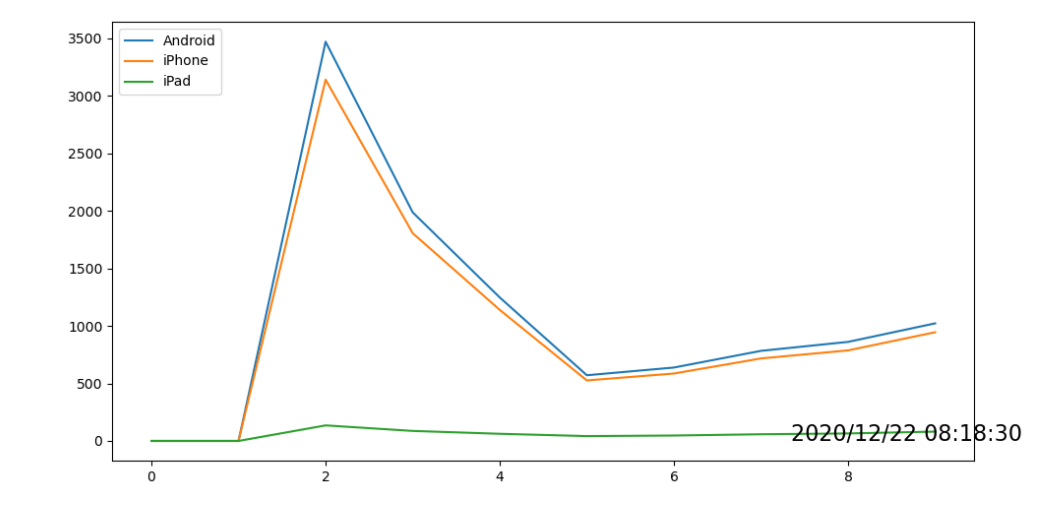

In [8]:
from IPython.display import Image
# kết quả chạy cho số lượng thiết bị đăng tweet
Image("image/line.png")

#### 3.2.1.1. Nhận xét
Từ đồ thị khảo sát trên, nếu quan sát từ thời điểm ban đầu mới vẽ thì đồ thị tăng rất nhanh sau đó giảm dần và đi vào ổn đinh dần. Nguyên nhân của hiện tượng này là các thông tin ban đầu đến chưa được hiển thị ra ngay mà mất một khoảng thời gian thì mới có thể tiếp nhận bình thường. Do đó, lượng thông tin ban đầu này tích lũy lại làm cho khoảng thời gian ngắn ban đầu tăng lên rất lớn sau đó mới có thể ổn định được.\\
Về khía cạnh số lượng các thiết bị truy cập thì có thể thấy số lượng truy cập của Android và Iphone là lớn hơn rất nhiều lần so với số liệu quan sát được ở Ipad. Trong tương quan giữa Android và Iphone, số lượng các thiết bị sản xuất bởi Apple có vẻ yếu thế về mặt số lượng hơn.

In [8]:
sparkSession.stop()

### 3.2.2 Khảo sát số lượng ngôn ngữ sử dụng đối với từng loại thiết bị
Đối với công việc thống kê này, nhóm tiến hành khảo sát đối với 3 loại thiết bị đã đề cập ở trên là Iphone, Ipad và Android. Trước khi đi vào xem xét cụ thể chúng ta cần phải lấy dữ liệu từ hdfs datanode ra trước:

In [1]:
from pyspark.sql import SparkSession
sparkSession = SparkSession.builder.appName("test4").getOrCreate()
dataframe = sparkSession.read.csv('hdfs://namenode:9000/chuc/data/partitionbyCountry')
dataframe.show()

+--------------------+---+-------------------+--------+----+
|                 _c0|_c1|                _c2|     day|hour|
+--------------------+---+-------------------+--------+----+
|          IFTTT | fr|  1|2020/12/23 12:02:00|20201223|  12|
|     ラブレター | ja|  1|2020/12/23 12:02:00|20201223|  12|
|       Twitt-RP | es|  1|2020/12/23 12:02:00|20201223|  12|
|BoomSonar-Suite | tr|  1|2020/12/23 12:02:00|20201223|  12|
|ShoutIRC Plugin | en|  1|2020/12/23 12:02:00|20201223|  12|
|Twitter for iPad ...|  1|2020/12/23 12:02:00|20201223|  12|
|Twitter for Andro...|254|2020/12/23 12:02:00|20201223|  12|
|    StreamFrBot | fr|  1|2020/12/23 12:02:00|20201223|  12|
|Twitter for Andro...|  2|2020/12/23 12:02:00|20201223|  12|
|     Integromat | en|  1|2020/12/23 12:02:00|20201223|  12|
|Twitter for Andro...|  2|2020/12/23 12:02:00|20201223|  12|
|The Social Jukebo...|  1|2020/12/23 12:02:00|20201223|  12|
|Revive Social App...|  1|2020/12/23 12:02:00|20201223|  12|
|Twitter for iPhon...| 84|202

Đối với công việc này, dữ liệu đã được xử lý qua spark streaming và đứa về dưới dạng dataframe có các thông số như sau:
+ Cột **_c0** là tên thiết bị đồng thời đi kèm ngôn ngữ viết tắt được tách với tên thiết bị bởi dấu "|"
+ Cột **_c1** là số lượng các thiết bị truy cập lấy trong từng khoảng thời gian 30s
+ Cột **_c2** là thời điểm bắt đầu đếm để ra số lượng các thiết bị trong cột **_c1**
+ Cột **day** là ngày tiến hành theo định dạng yyyy/mm/dd
+ Cột **hour** là giờ tương ứng với quá trình đếm

Tương tự với trường hợp khảo sát trên, chúng ta cũng cần xây dựng một hàm để trích xuất các đặc trưng yêu cầu:

In [2]:
from datetime import datetime
from pyspark.sql.functions import *
def getslot_nation(df, device_type, stoptime, interval):
    '''
    Hàm lấy số lượng các ngôn ngữ được sử dụng nhiều nhất bởi một loại thiết bị
    @df: dataframe cần trích xuất
    @device_type: loại thiết bị quan tâm
    @stoptime: thời điểm dừng trích xuất
    @interval: khoảng thời gian trích xuất
    '''
    stop_time=datetime.strptime(stoptime, '%Y/%m/%d %H:%M:%S').timestamp()
    start_time= datetime.strftime(datetime.fromtimestamp(stop_time - interval), '%Y/%m/%d %H:%M:%S')
    print(start_time)
    caredata= df.filter((df._c2 >= start_time) & (df._c2 <= stoptime))
    
    #trích xuất loại thiết bị quan tâm
    caredata= caredata[caredata._c0.contains(device_type)] #vd: device_type= "Twitter for Android"
    #lấy hai ký tự cuôi đặc trưng cho ngôn ngữ
    caredata= caredata.withColumn('lang', substring('_c0', -2,2))
    caredata= caredata.drop("_c0")
    caredata= caredata.withColumn("int_res",caredata["_c1"].cast("int"))
    caredata= caredata.drop("_c1")
    #lấy tổng số lượng thiết bị sử dụng theo ngôn ngữ
    caredata= caredata.groupBy("lang").agg(sum("int_res"))
    # lấy 10 ngôn ngữ hay được sử dụng nhất
    caredata= caredata.sort(desc("sum(int_res)")).limit(10)
    return caredata

Hàm hỗ trợ vẽ biểu đồ thay đổi

In [3]:
!pip install langcodes

     |████████████████████████████████| 5.0 MB 1.1 MB/s eta 0:00:01
     |████████████████████████████████| 270 kB 2.3 MB/s eta 0:00:01
  Created wheel for langcodes: filename=langcodes-2.1.0-py3-none-any.whl size=5068032 sha256=99b2e5b2bced1bd0ef24a6be7d1efd1facb2527da3c022a1777c470a873a33b7
  Stored in directory: /home/jovyan/.cache/pip/wheels/c7/ea/ff/8a5b34733a82c9a782b2bcad6705a443e11638db2d5442f506
  Created wheel for marisa-trie: filename=marisa_trie-0.7.5-cp38-cp38-linux_x86_64.whl size=1257127 sha256=a69cff352dde08dc1b67db46e0d3f9a784128f979f7f90322648b585a6e3167e
  Stored in directory: /home/jovyan/.cache/pip/wheels/15/c1/11/eca4af1428d995e64d18232d403f8e676dd80d214a5847e858
Successfully built langcodes marisa-trie


#### 3.2.2.1 Khảo sát ngôn ngữ theo thiết bị Android

In [ ]:
import time
import psutil
import matplotlib.pyplot as plt
import random
import numpy as np
from datetime import datetime
from langcodes import Language
%matplotlib notebook
plt.rcParams['animation.html'] = 'jshtml'
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111)
fig.show()

# stopTime = "2020/12/22 08:15:00"
stopTime = "2020/12/23 11:45:31"
interval = 15*60
subTime = 30

colors = ['#b61827','#4d2c91','#0077c2','#0095a8','#338a3e','#a0af22','#c79a00','#c63f17','#8d8d8d','#009624']
#colors = ['#adb0ff','#ffb3ff','#90d595','#e48381','#aafbff', '#f7bb5f', '#eafb50','#b2dfdb','#ffca28','#a1887f']
ls = []
def showDevice(type_device):
    global stopTime
    x = np.arange(10)
    i = 0
    while True:
        df =  getslot_nation(dataframe,type_device,stopTime,15*60).collect()
        ax.clear()
        y_vals= [df[i][1] for i in range(9,-1,-1)]
#         z_vals = ["en","fr","hi","en","ls","hi","en","ls","fr","en"]
        z_vals= [df[i][0] for i in range(9,-1,-1)]
        listC = []
        for z in z_vals:
            if not z in ls:
                ls.append(z);
        for z in z_vals:
            for i in range(len(ls)):
                if z==ls[i]:
                    listC.append(colors[i%10])
        ax.barh(x, y_vals, color=listC)
        dx = 0
        for i in y_vals:
            if dx < i:
                dx=i
        dx= dx/200.0
        ax.set_yticks([])
        for i, (name,value) in enumerate(zip(z_vals,y_vals)):
            ax.text(value-dx, i,     Language.make(language=name).display_name(),    size=14,  ha='right')
            ax.text(value+dx, i,    value,  size=14, ha='left')
        ax.text(1, 0.02, stopTime, transform=ax.transAxes, size=14, ha='right', weight=800)
        ax.text(0, 1.07, 'Top ten language for Android ', transform=ax.transAxes, size=22, weight=600, ha='left') 
        ax.text(0, 1.02, 'Số lượng tweet', transform=ax.transAxes, size=12, color='#777777')
        fig.canvas.draw()
        time.sleep(1)
        i += 1
        stop_time=datetime.strptime(stopTime, '%Y/%m/%d %H:%M:%S').timestamp()
        netStopTime= datetime.strftime(datetime.fromtimestamp(stop_time + subTime), '%Y/%m/%d %H:%M:%S')
        stopTime = netStopTime
        #print("abc")
showDevice("Twitter for Android") 
# df =  getslot_nation(dataframe,"Twitter for Android",stopTime,15*60).collect()
# print(df[1])
# print(df[0])

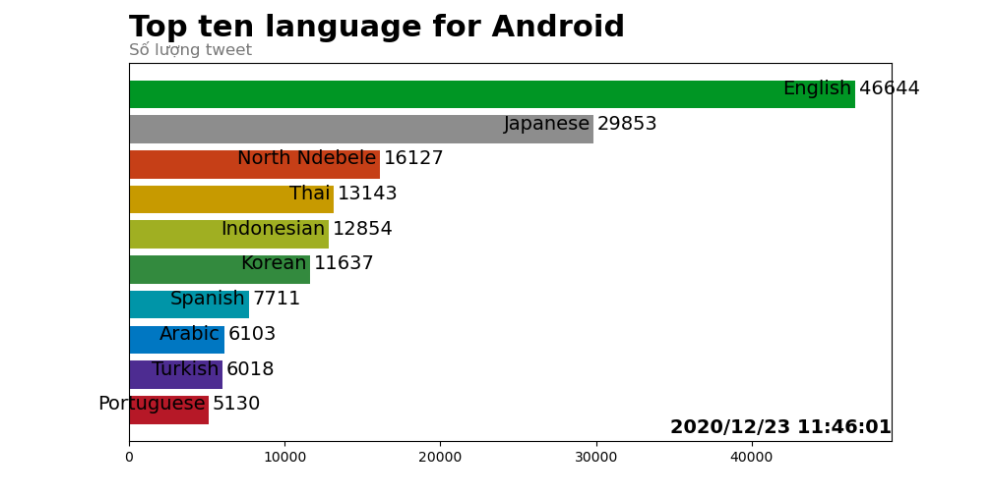

In [9]:
# kết quả chạy độ phổ biến của các ngôn ngữ trong các thiết bị Android
Image("image/bar1.png")

#### 3.2.2.2. Khảo sát ngôn ngữ theo thiết bị Iphone

In [ ]:
import time
import psutil
import matplotlib.pyplot as plt
import random
import numpy as np
from datetime import datetime
from langcodes import Language
%matplotlib notebook
plt.rcParams['animation.html'] = 'jshtml'
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111)
fig.show()

# stopTime = "2020/12/22 08:15:00"
stopTime = "2020/12/23 11:45:31"
interval = 15*60
subTime = 30

colors = ['#b61827','#4d2c91','#0077c2','#0095a8','#338a3e','#a0af22','#c79a00','#c63f17','#8d8d8d','#009624']
#colors = ['#adb0ff','#ffb3ff','#90d595','#e48381','#aafbff', '#f7bb5f', '#eafb50','#b2dfdb','#ffca28','#a1887f']
ls = []
def showDevice(type_device):
    global stopTime
    x = np.arange(10)
    i = 0
    while True:
        df =  getslot_nation(dataframe,type_device,stopTime,15*60).collect()
        ax.clear()
        y_vals= [df[i][1] for i in range(9,-1,-1)]
#         z_vals = ["en","fr","hi","en","ls","hi","en","ls","fr","en"]
        z_vals= [df[i][0] for i in range(9,-1,-1)]
        listC = []
        for z in z_vals:
            if not z in ls:
                ls.append(z);
        for z in z_vals:
            for i in range(len(ls)):
                if z==ls[i]:
                    listC.append(colors[i%10])
        ax.barh(x, y_vals, color=listC)
        dx = 0
        for i in y_vals:
            if dx < i:
                dx=i
        dx= dx/200.0
        ax.set_yticks([])
        for i, (name,value) in enumerate(zip(z_vals,y_vals)):
            ax.text(value-dx, i,     Language.make(language=name).display_name(),    size=14,  ha='right')
            ax.text(value+dx, i,    value,  size=14, ha='left')
        ax.text(1, 0.02, stopTime, transform=ax.transAxes, size=14, ha='right', weight=800)
        ax.text(0, 1.07, 'Top ten language for Iphone ', transform=ax.transAxes, size=22, weight=600, ha='left') 
        ax.text(0, 1.02, 'Số lượng tweet', transform=ax.transAxes, size=12, color='#777777')
        fig.canvas.draw()
        time.sleep(1)
        i += 1
        stop_time=datetime.strptime(stopTime, '%Y/%m/%d %H:%M:%S').timestamp()
        netStopTime= datetime.strftime(datetime.fromtimestamp(stop_time + subTime), '%Y/%m/%d %H:%M:%S')
        stopTime = netStopTime
        #print("abc")
showDevice("Twitter for iPhone") 

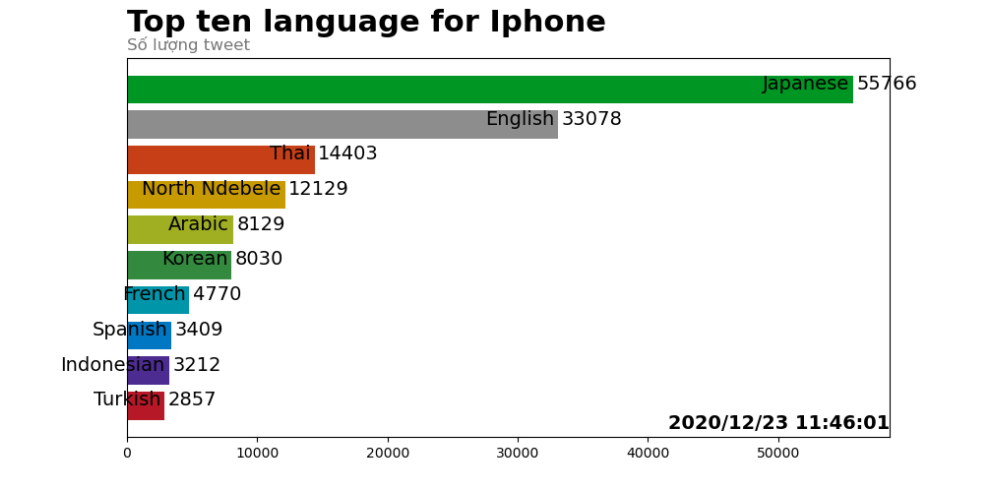

In [10]:
# kết quả chạy độ phổ biến của các ngôn ngữ trong các thiết bị Iphone
Image("image/bar2.png")

#### 3.2.2.3. Khảo sát ngôn ngữ theo thiết bị Ipad

In [ ]:
import time
import psutil
import matplotlib.pyplot as plt
import random
import numpy as np
from datetime import datetime
from langcodes import Language
%matplotlib notebook
plt.rcParams['animation.html'] = 'jshtml'
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111)
fig.show()

# stopTime = "2020/12/22 08:15:00"
stopTime = "2020/12/23 11:45:31"
interval = 15*60
subTime = 30

colors = ['#b61827','#4d2c91','#0077c2','#0095a8','#338a3e','#a0af22','#c79a00','#c63f17','#8d8d8d','#009624']
#colors = ['#adb0ff','#ffb3ff','#90d595','#e48381','#aafbff', '#f7bb5f', '#eafb50','#b2dfdb','#ffca28','#a1887f']
ls = []
def showDevice(type_device):
    global stopTime
    x = np.arange(10)
    i = 0
    while True:
        df =  getslot_nation(dataframe,type_device,stopTime,15*60).collect()
        ax.clear()
        y_vals= [df[_][1] for _ in range(9,-1,-1)]
#         z_vals = ["en","fr","hi","en","ls","hi","en","ls","fr","en"]
        z_vals= [df[_][0] for _ in range(9,-1,-1)]
        listC = []
        for z in z_vals:
            if not z in ls:
                ls.append(z);
        for z in z_vals:
            for ix in range(len(ls)):
                if z==ls[ix]:
                    listC.append(colors[ix%10])
        ax.barh(x, y_vals, color=listC)
        dx = 0
        for iy in y_vals:
            if dx < iy:
                dx=iy
        dx= dx/200.0
        ax.set_yticks([])
        for i, (name,value) in enumerate(zip(z_vals,y_vals)):
            ax.text(value-dx, i,     Language.make(language=name).display_name(),    size=14,  ha='right')
            ax.text(value+dx, i,    value,  size=14, ha='left')
        ax.text(1, 0.02, stopTime, transform=ax.transAxes, size=14, ha='right', weight=800)
        ax.text(0, 1.07, 'Top ten language for Ipad', transform=ax.transAxes, size=22, weight=600, ha='left') 
        ax.text(0, 1.02, 'Số lượng tweet', transform=ax.transAxes, size=12, color='#777777')
        fig.canvas.draw()
        time.sleep(1)
        i += 1
        stop_time=datetime.strptime(stopTime, '%Y/%m/%d %H:%M:%S').timestamp()
        netStopTime= datetime.strftime(datetime.fromtimestamp(stop_time + subTime), '%Y/%m/%d %H:%M:%S')
        stopTime = netStopTime
        #print("abc")
showDevice("Twitter for iPad")

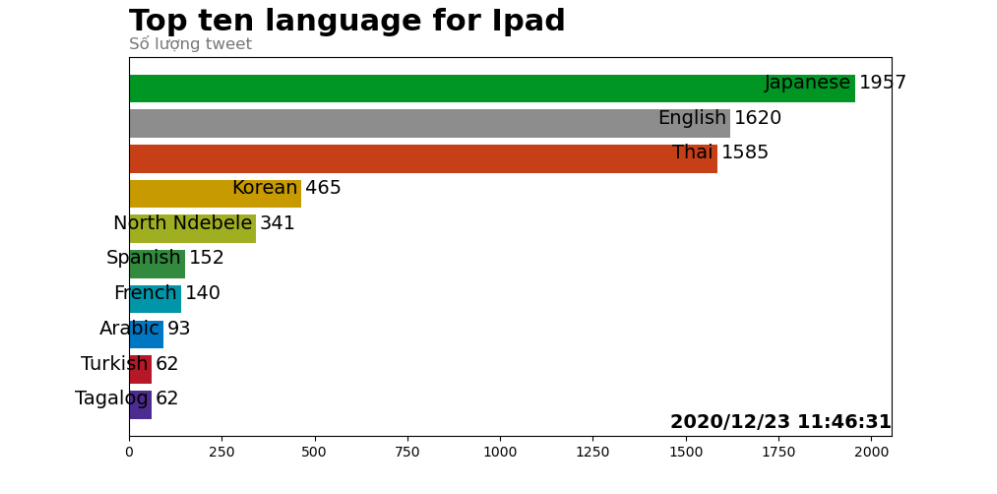

In [11]:
# kết quả chạy độ phổ biến của các ngôn ngữ trong các thiết bị Ipad
Image("image/bar3.png")

In [30]:
sparkSession.stop()